In [1]:
from datasets import Dataset, DatasetDict, load_metric, load_dataset
import numpy as np
import os
from PIL import Image

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (  # Import image transformation functions
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import itertools  # Import 'itertools' for iterators and looping

### Reading data using load_dataset method from dataset library

In [2]:
data_path = 'data/affectnet/train_images'
dataset = load_dataset("imagefolder", data_dir=data_path)

print(dataset)
print(dataset['train'][0])
print(dataset['train'].features)

Resolving data files:   0%|          | 0/28953 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28953
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x20C4C5AE280>, 'label': 0}
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)}


### Define the checkpoint for the pre-trained Vision Transformer model

In [3]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

c:\Users\kris\Anaconda3\envs\cs731\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kris\.cache\huggingface\hub\models--motheecreator--vit-Facial-Expression-Recognition. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Set label-to-ID and ID-to-label mappings

In [4]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

label2id

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

### Apply data transformations

In [5]:
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = image_processor.image_mean, image_processor.image_std
# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]
# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
train_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                          # Normalize images using mean and std
    ]
)
# Define a set of transformations for validation data
val_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

print(size)


Size:  224


### Split up training into training + validation

In [6]:
splits = dataset["train"].train_test_split(test_size=0.20)
train_data = splits['train']
val_data = splits['test']

print(train_data)
print(val_data)

Dataset({
    features: ['image', 'label'],
    num_rows: 23162
})
Dataset({
    features: ['image', 'label'],
    num_rows: 5791
})


### Saving the data to load the same data for training other models

In [7]:
train_data.save_to_disk("data/dataset/train_data")
train_data.with_format(None).save_to_disk("data/dataset/train_data")
val_data.with_format(None).save_to_disk("data/dataset/val_data")

### Define specific transformations to be applied for training and validation datasets

In [9]:
# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

train_data.set_transform(train_transforms)
val_data.set_transform(val_transforms)
train_data[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96>,
 'label': 4,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -

### Loading pre-trained model

In [10]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True
)

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at motheecreator/vit-Facial-Expression-Recognition and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set up the training arguments

In [12]:
model_name = "vit-affectnet-emotion-recognition"

args = TrainingArguments(
    f"{model_name}",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    auto_find_batch_size=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    num_train_epochs=10,
    warmup_steps=1000,
    logging_steps=50,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="none"
)

c:\Users\kris\Anaconda3\envs\cs731\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Define metrics to compute while training

In [13]:
from datasets import load_metric

metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

C:\Users\kris\AppData\Local\Temp\ipykernel_21784\2863964228.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


### Set up the Trainer class to handle training, evaluation, and inference

In [14]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=image_processor, # Tokenizer or processor to handle inputs
    compute_metrics=compute_metrics, # Function to compute evaluation metrics
    data_collator=collate_fn, # Data collator to format input batches
)

### Training the model

In [15]:
train_results = trainer.train()

  0%|          | 0/900 [00:00<?, ?it/s]

{'loss': 2.1249, 'grad_norm': 1.8189386129379272, 'learning_rate': 1.5e-06, 'epoch': 0.55}
{'loss': 2.0082, 'grad_norm': 1.4373865127563477, 'learning_rate': 3e-06, 'epoch': 1.1}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 1.9282768964767456, 'eval_accuracy': 0.4448281816611984, 'eval_runtime': 76.5422, 'eval_samples_per_second': 75.658, 'eval_steps_per_second': 2.365, 'epoch': 1.1}
{'loss': 1.7828, 'grad_norm': 1.298155665397644, 'learning_rate': 4.5e-06, 'epoch': 1.66}
{'loss': 1.4931, 'grad_norm': 1.0130170583724976, 'learning_rate': 6e-06, 'epoch': 2.21}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 1.3533469438552856, 'eval_accuracy': 0.6394405111379727, 'eval_runtime': 76.721, 'eval_samples_per_second': 75.481, 'eval_steps_per_second': 2.359, 'epoch': 2.21}
{'loss': 1.2587, 'grad_norm': 1.0539394617080688, 'learning_rate': 7.5e-06, 'epoch': 2.76}
{'loss': 1.1046, 'grad_norm': 1.0659412145614624, 'learning_rate': 9e-06, 'epoch': 3.31}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 1.0195529460906982, 'eval_accuracy': 0.7168019340355725, 'eval_runtime': 76.2462, 'eval_samples_per_second': 75.951, 'eval_steps_per_second': 2.374, 'epoch': 3.31}
{'loss': 1.0, 'grad_norm': 1.21951425075531, 'learning_rate': 1.05e-05, 'epoch': 3.87}
{'loss': 0.9112, 'grad_norm': 1.3264625072479248, 'learning_rate': 1.2e-05, 'epoch': 4.42}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 0.8729209303855896, 'eval_accuracy': 0.7433949231566224, 'eval_runtime': 77.6952, 'eval_samples_per_second': 74.535, 'eval_steps_per_second': 2.33, 'epoch': 4.42}
{'loss': 0.8842, 'grad_norm': 1.2737517356872559, 'learning_rate': 1.3500000000000001e-05, 'epoch': 4.97}
{'loss': 0.8155, 'grad_norm': 1.6722055673599243, 'learning_rate': 1.5e-05, 'epoch': 5.52}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 0.7933667898178101, 'eval_accuracy': 0.7587635986876187, 'eval_runtime': 75.757, 'eval_samples_per_second': 76.442, 'eval_steps_per_second': 2.389, 'epoch': 5.52}
{'loss': 0.8109, 'grad_norm': 1.7301311492919922, 'learning_rate': 1.65e-05, 'epoch': 6.08}
{'loss': 0.7618, 'grad_norm': 1.408998727798462, 'learning_rate': 1.8e-05, 'epoch': 6.63}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 0.7451601028442383, 'eval_accuracy': 0.769815230530133, 'eval_runtime': 77.2514, 'eval_samples_per_second': 74.963, 'eval_steps_per_second': 2.343, 'epoch': 6.63}
{'loss': 0.7396, 'grad_norm': 2.1006815433502197, 'learning_rate': 1.95e-05, 'epoch': 7.18}
{'loss': 0.7103, 'grad_norm': 1.6387145519256592, 'learning_rate': 2.1e-05, 'epoch': 7.73}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 0.7121745347976685, 'eval_accuracy': 0.771024002762908, 'eval_runtime': 76.4252, 'eval_samples_per_second': 75.773, 'eval_steps_per_second': 2.368, 'epoch': 7.73}
{'loss': 0.7043, 'grad_norm': 2.128732442855835, 'learning_rate': 2.25e-05, 'epoch': 8.29}
{'loss': 0.6775, 'grad_norm': 1.7319979667663574, 'learning_rate': 2.4e-05, 'epoch': 8.84}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 0.6957072615623474, 'eval_accuracy': 0.7767225004317043, 'eval_runtime': 76.2172, 'eval_samples_per_second': 75.98, 'eval_steps_per_second': 2.375, 'epoch': 8.84}
{'loss': 0.6521, 'grad_norm': 1.4850696325302124, 'learning_rate': 2.55e-05, 'epoch': 9.39}
{'loss': 0.6518, 'grad_norm': 1.8934037685394287, 'learning_rate': 2.7000000000000002e-05, 'epoch': 9.94}


  0%|          | 0/181 [00:00<?, ?it/s]

{'eval_loss': 0.6965085864067078, 'eval_accuracy': 0.7717147297530651, 'eval_runtime': 77.6551, 'eval_samples_per_second': 74.573, 'eval_steps_per_second': 2.331, 'epoch': 9.94}
{'train_runtime': 9112.3598, 'train_samples_per_second': 25.418, 'train_steps_per_second': 0.099, 'train_loss': 1.0606424077351888, 'epoch': 9.94}


### Evaluating the model

In [16]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/181 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =     9.9448
  eval_accuracy           =     0.7717
  eval_loss               =     0.6965
  eval_runtime            = 0:01:03.11
  eval_samples_per_second =      91.76
  eval_steps_per_second   =      2.868


In [17]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(val_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

  0%|          | 0/181 [00:00<?, ?it/s]

{'test_loss': 0.6965085864067078, 'test_accuracy': 0.7717147297530651, 'test_runtime': 66.0675, 'test_samples_per_second': 87.653, 'test_steps_per_second': 2.74}


### Calculate metrics and create confusion matrix

Accuracy: 0.7717
F1 Score: 0.7400


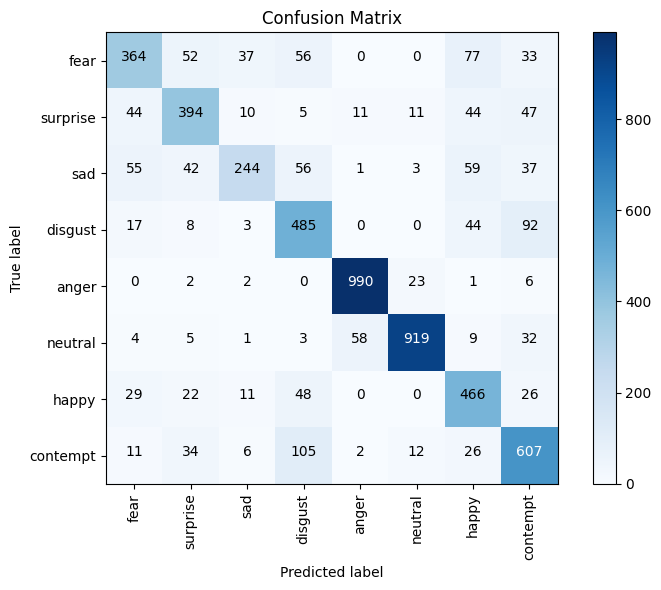


Classification report:

              precision    recall  f1-score   support

        fear     0.6947    0.5880    0.6369       619
    surprise     0.7048    0.6961    0.7004       566
         sad     0.7771    0.4909    0.6017       497
     disgust     0.6398    0.7473    0.6894       649
       anger     0.9322    0.9668    0.9492      1024
     neutral     0.9494    0.8914    0.9195      1031
       happy     0.6419    0.7741    0.7018       602
    contempt     0.6898    0.7559    0.7213       803

    accuracy                         0.7717      5791
   macro avg     0.7537    0.7388    0.7400      5791
weighted avg     0.7778    0.7717    0.7700      5791



In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score  

labels_list = list(set(labels))

# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))